In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd

# Assuming your file is in Excel format, use read_excel
data = pd.read_excel('/content/drive/MyDrive/customer/customercon_data1_1.xlsx')
data.head()

,year,TopSalesAmount,TopFiveSalesAmount,GrossRevenue,TopCustomerToTotalRatio,CustomerConcentration,CustomerConcentrationHHI,SupplyChainConcentration
0,2012,1.058796e+09,1.900515e+09,1.030000e+11,1.030,1.85,0.012397,0.93
1,2013,1.189264e+09,2.823094e+09,1.350000e+11,0.880,2.09,0.012699,1.05
2,2014,1.325572e+08,1.210000e+09,1.460000e+11,9.675,0.83,1.876500,1.92
3,2015,1.325572e+08,2.697000e+09,1.960000e+11,9.675,2.98,1.876500,1.99
4,2016,1.325572e+08,2.140000e+09,2.400000e+11,9.675,0.90,1.876500,1.49


In [13]:
X = data.drop(['CustomerConcentration'], axis=1)
y = data['CustomerConcentration']

# Display the modified feature dataset
print(X)

# Display the target dataset
print(y)


       year  TopSalesAmount  TopFiveSalesAmount  GrossRevenue  \
0      2012    1.058796e+09        1.900515e+09  1.030000e+11   
1      2013    1.189264e+09        2.823094e+09  1.350000e+11   
2      2014    1.325572e+08        1.210000e+09  1.460000e+11   
3      2015    1.325572e+08        2.697000e+09  1.960000e+11   
4      2016    1.325572e+08        2.140000e+09  2.400000e+11   
...     ...             ...                 ...           ...   
27252  2015    4.788678e+07        5.207224e+07  5.207224e+07   
27253  2017    1.325572e+08        9.811000e+07  9.811317e+07   
27254  2018    1.325572e+08        1.061100e+08  1.061131e+08   
27255  2019    1.325572e+08        1.050200e+08  1.050223e+08   
27256  2020    1.325572e+08        9.941000e+07  9.940559e+07   

       TopCustomerToTotalRatio  CustomerConcentrationHHI  \
0                        1.030                  0.012397   
1                        0.880                  0.012699   
2                        9.675         

In [14]:
# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Selected Features: Index(['year', 'TopSalesAmount', 'TopFiveSalesAmount', 'GrossRevenue',
       'TopCustomerToTotalRatio', 'CustomerConcentrationHHI',
       'SupplyChainConcentration'],
      dtype='object')
Mean Squared Error with Selected Features: 16.255593767577032


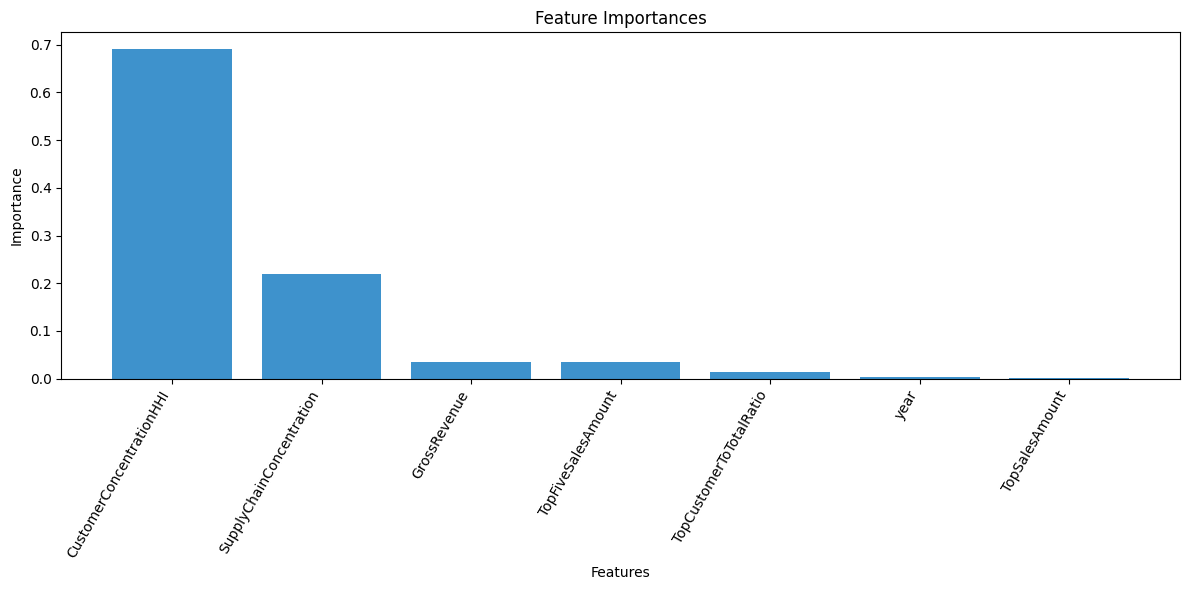

In [18]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import random

# A simple Ant Colony Optimization implementation for feature selection

# Define the parameters for ACO
num_ants = 1
num_features = X_train.shape[1]
num_iterations = 5
evaporation_rate = 0.5
alpha = 1
beta = 2

# Initialize pheromone levels
pheromones = np.ones(num_features)

# Define the heuristic information (can be uniform)
heuristic = np.ones(num_features)

# Define the probability of selecting each feature
def calculate_probabilities(pheromones, heuristic, alpha, beta):
    return (pheromones ** alpha) * (heuristic ** beta)

# Define the fitness function to evaluate a subset of features
def evaluate_feature_subset(features, X_train, y_train, X_val, y_val):
    X_train_subset = X_train[:, features]
    X_val_subset = X_val[:, features]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_subset, y_train)

    y_pred = model.predict(X_val_subset)
    mse = mean_squared_error(y_val, y_pred)

    return -mse

# Main ACO loop
best_solution = None
best_score = float('-inf')

for iteration in range(num_iterations):
    all_solutions = []
    all_scores = []

    for ant in range(num_ants):
        solution = []

        for feature in range(num_features):
            if random.random() < calculate_probabilities(pheromones[feature], heuristic[feature], alpha, beta):
                solution.append(feature)

        if len(solution) == 0:
            solution = random.sample(range(num_features), k=random.randint(1, num_features))

        all_solutions.append(solution)
        score = evaluate_feature_subset(solution, X_train.values, y_train.values, X_val.values, y_val.values)
        all_scores.append(score)

        if score > best_score:
            best_score = score
            best_solution = solution

    # Update pheromones
    for feature in range(num_features):
        pheromones[feature] *= (1 - evaporation_rate)

        for solution, score in zip(all_solutions, all_scores):
            if feature in solution:
                pheromones[feature] += score

# Display the selected features and their importance
selected_features = X_train.columns[best_solution]
print(f'Selected Features: {selected_features}')

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model = RandomForestRegressor(random_state=42)
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with Selected Features: {mse}')

# Assuming the model has already been trained and `importances` is available
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='#3e92cc', align='center')
plt.xticks(range(len(indices)), [selected_features[i] for i in indices], rotation=60, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


Selected Features: Index(['TopSalesAmount', 'CustomerConcentrationHHI', 'TopFiveSalesAmount',
       'TopCustomerToTotalRatio', 'SupplyChainConcentration', 'year',
       'GrossRevenue'],
      dtype='object')
Mean Squared Error with Selected Features: 16.25062831828136


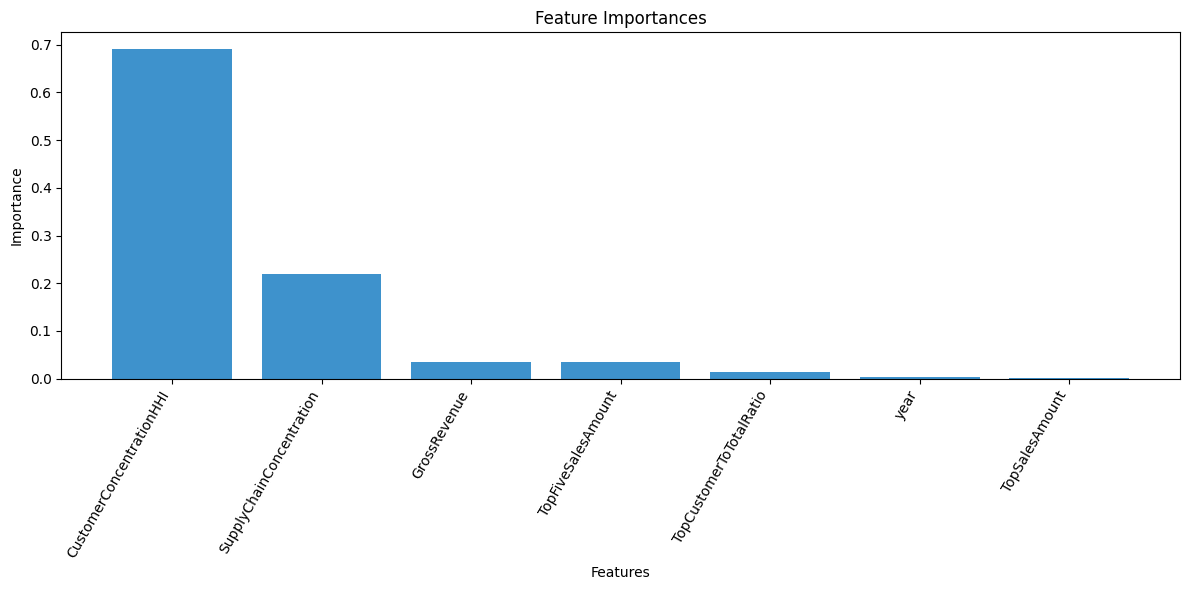

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import random

# A simple Ant Colony Optimization implementation for feature selection

# Define the parameters for ACO
num_ants = 5
num_features = X_train.shape[1]
num_iterations = 20
evaporation_rate = 0.5
alpha = 1
beta = 2

# Initialize pheromone levels
pheromones = np.ones(num_features)

# Define the heuristic information (can be uniform)
heuristic = np.ones(num_features)

# Define the probability of selecting each feature
def calculate_probabilities(pheromones, heuristic, alpha, beta):
    return (pheromones ** alpha) * (heuristic ** beta)

# Define the fitness function to evaluate a subset of features
def evaluate_feature_subset(features, X_train, y_train, X_val, y_val):
    X_train_subset = X_train[:, features]
    X_val_subset = X_val[:, features]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_subset, y_train)

    y_pred = model.predict(X_val_subset)
    mse = mean_squared_error(y_val, y_pred)

    return -mse

# Main ACO loop
best_solution = None
best_score = float('-inf')

for iteration in range(num_iterations):
    all_solutions = []
    all_scores = []

    for ant in range(num_ants):
        solution = []

        for feature in range(num_features):
            if random.random() < calculate_probabilities(pheromones[feature], heuristic[feature], alpha, beta):
                solution.append(feature)

        if len(solution) == 0:
            solution = random.sample(range(num_features), k=random.randint(1, num_features))

        all_solutions.append(solution)
        score = evaluate_feature_subset(solution, X_train.values, y_train.values, X_val.values, y_val.values)
        all_scores.append(score)

        if score > best_score:
            best_score = score
            best_solution = solution

    # Update pheromones
    for feature in range(num_features):
        pheromones[feature] *= (1 - evaporation_rate)

        for solution, score in zip(all_solutions, all_scores):
            if feature in solution:
                pheromones[feature] += score

# Display the selected features and their importance
selected_features = X_train.columns[best_solution]
print(f'Selected Features: {selected_features}')

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model = RandomForestRegressor(random_state=42)
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with Selected Features: {mse}')

# Assuming the model has already been trained and `importances` is available
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='#3e92cc', align='center')
plt.xticks(range(len(indices)), [selected_features[i] for i in indices], rotation=60, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
